In [1]:
import os
import json
import numpy as np
from utils import data_utils
import matplotlib.pyplot as plt
from torchvision.io import read_image
from copy import deepcopy
import datasets

In [2]:
fashion_prefab_path="./simmc2/data/fashion_prefab_metadata_all.json"
furniture_prefab_path="./simmc2/data/furniture_prefab_metadata_all.json"

fashion_prefab = json.loads(open(fashion_prefab_path).read())
furniture_prefab = json.loads(open(furniture_prefab_path).read())

In [3]:
cats = data_utils.load_categories() # Category Dict
cats

{'categories': [{'supercategory': 'fashion', 'id': 0, 'name': 'sweater'},
  {'supercategory': 'fashion', 'id': 1, 'name': 'shirt'},
  {'supercategory': 'fashion', 'id': 2, 'name': 'dress'},
  {'supercategory': 'fashion', 'id': 3, 'name': 'skirt'},
  {'supercategory': 'fashion', 'id': 4, 'name': 'trousers'},
  {'supercategory': 'fashion', 'id': 5, 'name': 'shirt, vest'},
  {'supercategory': 'fashion', 'id': 6, 'name': 'jacket'},
  {'supercategory': 'fashion', 'id': 7, 'name': 'tshirt'},
  {'supercategory': 'fashion', 'id': 8, 'name': 'jeans'},
  {'supercategory': 'fashion', 'id': 9, 'name': 'joggers'},
  {'supercategory': 'fashion', 'id': 10, 'name': 'hat'},
  {'supercategory': 'fashion', 'id': 11, 'name': 'blouse'},
  {'supercategory': 'fashion', 'id': 12, 'name': 'coat'},
  {'supercategory': 'fashion', 'id': 13, 'name': 'hoodie'},
  {'supercategory': 'fashion', 'id': 14, 'name': 'suit'},
  {'supercategory': 'fashion', 'id': 15, 'name': 'shoes'},
  {'supercategory': 'fashion', 'id': 16

In [4]:

data_path = './preprocessed_data/coref_candidates|no_mm/simmc2.1_coref_candidates_dstc11_train.json'
img_dir_paths = [
    './simmc2/data/simmc2_scene_images_dstc10_public_part1',
    './simmc2/data/simmc2_scene_images_dstc10_public_part2'
]

def load_image_text_eval_dataset(
    num_utterances = 3,
    scene_dir_path = "./simmc2/data/public", 
    data_path = data_path,
    img_dir_paths = img_dir_paths,
):
    with open(data_path, "r") as file_id:
        raw_data = json.load(file_id)    
        source_data = json.load(open(raw_data['source_path'],'r'))
    data = raw_data["data"]
    gt_data = source_data
    
    dset = {
        'utterance_id': [], 'object_id': [],
        'text': [], 'image': [], 'bbox': []
    }
    for row in data:
        # Dialogue idx to labels
        dialog_id = row['dialog_id']
        turn_id = row['turn_id']
        labels = row['ambiguous_candidates']

        # Scene
        scene_path = row['image_name'].replace('.png','_scene.json')
        if os.path.exists(f"{scene_dir_path}/{scene_path}"):
            scene_path = f"{scene_dir_path}/{scene_path}"
        elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
            scene_path = f"{scene_dir_path}/m_{scene_path}"

        scene = json.load(open(scene_path, 'r'))
        scene_dict = {}
        for scene_objects in scene['scenes']:
            for obj in scene_objects['objects']:
                scene_dict[obj['unique_id']] = obj['bbox']

        image_path = row['image_name']
        for img_dir_path in img_dir_paths:
            if os.path.exists(f'{img_dir_path}/{image_path}'):
                image_path = f'{img_dir_path}/{image_path}'
                break

        dialogue = deepcopy(data[0]["input_text"])
        for turn_id, turn in enumerate(dialogue):
            if turn_id % 2 == 0:
                dialogue[turn_id] = "<USER> " + turn
            else:
                dialogue[turn_id] = "<SYS> " + turn
        text = " ".join(dialogue[-num_utterances:])

        for obj_id, bbox in scene_dict.items():
            dset['utterance_id'].append(f'{dialog_id}_{turn_id}') # utterance_id = {dialog_id}_{turn_id}
            dset['object_id'].append(obj_id)
            dset['text'].append(text)
            dset['image'].append(image_path)
            dset['bbox'].append(bbox)
    eval_dset = datasets.Dataset.from_dict(dset)
    eval_dset = eval_dset.cast_column("image", datasets.Image(decode=True))
    
    return eval_dset, gt_data, raw_data

In [5]:
with open(data_path, "r") as file_id:
    raw_data = json.load(file_id)    
    source_data = json.load(open(raw_data['source_path'],'r'))
data = raw_data["data"]
gt_data = source_data['dialogue_data']

In [6]:
for row in raw_data['data']:
    if row['dialog_id'] == 1422 and row['turn_id'] == 1:
        break

In [7]:

scene_dir_path = "./simmc2/data/public"

In [8]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

def show_dialogue(dialogue_data):
    utterances = []
    for turn_id, turn in enumerate(dialogue_data['input_text']):
        if turn_id % 2 == 0:
            utterances.append("U: " + turn)
        else:
            utterances.append("S: " + turn)
    print("\n".join(utterances))

def show_image(dialogue_data, draw_bbox=True, img_dir_paths=img_dir_paths):
    image_path = dialogue_data['image_name']
    for img_dir_path in img_dir_paths:
        if os.path.exists(f'{img_dir_path}/{image_path}'):
            image_path = f'{img_dir_path}/{image_path}'
            break
    image = Image.open(image_path).convert("RGB")
    
    if draw_bbox:
        scene_path = dialogue_data['image_name'].replace('.png','_scene.json')
        if os.path.exists(f"{scene_dir_path}/{scene_path}"):
            scene_path = f"{scene_dir_path}/{scene_path}"
        elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
            scene_path = f"{scene_dir_path}/m_{scene_path}"
        scene = json.load(open(scene_path, 'r'))
        object_map = dialogue_data['object_map']

        scene_objects = scene['scenes'][0]['objects']
        index_map = {obj['index']: obj_id for obj_id, obj in zip(object_map, scene_objects)}
        draw = ImageDraw.Draw(image)
        font = ImageFont.truetype("fonts/ArialTh.ttf", 40)
        for obj in scene_objects:
            if index_map[obj['index']] in dialogue_data['ambiguous_candidates']:
                bbox, prefab = obj['bbox'], obj['prefab_path']
                if prefab in furniture_prefab:
                    name = furniture_prefab[prefab]['type']
                else: # Fashion
                    name = fashion_prefab[prefab]['assetType']

                for i in range(-2, 3):
                    draw.rectangle(((bbox[0] + i, bbox[1] + i), (bbox[0] + i + bbox[3], bbox[1] + bbox[2] + i)), outline="red")
                draw.text((bbox[0], max(0, bbox[1]-40)), name, fill='red', font=font)
                print(((bbox[0], bbox[1]), (bbox[0] + bbox[3], bbox[1] + bbox[2])))
    plt.imshow(image)

In [9]:
print(raw_data["data"][0])
len(raw_data["data"])

{'dialog_id': 12304, 'turn_id': 0, 'input_text': ['Hi, do you have any jackets today?'], 'object_map': [59, 80, 55, 67, 68, 70, 82, 79, 69, 72, 71, 73, 61, 62, 63, 58, 74, 75, 64, 76], 'image_name': 'cloth_store_1498649_woman_5_3.png', 'ambiguous_candidates': []}


38127

In [10]:
blank_counter = 0
for i in range(len(raw_data["data"])):
    if raw_data["data"][i]["ambiguous_candidates"] == []:
        blank_counter += 1
    else:
        print(i, raw_data["data"][i]["ambiguous_candidates"])
print(blank_counter)

1 [59, 82]
3 [55]
8 [1, 2]
12 [1, 2]
13 [8, 2]
14 [8, 1]
18 [56]
20 [64, 63]
21 [68, 55]
23 [63, 68]
25 [55]
29 [7]
30 [7]
32 [2, 8]
35 [8, 1]
37 [7]
39 [2, 1]
40 [2]
42 [1, 2]
45 [85]
49 [63]
51 [65, 70]
53 [64, 63]
56 [15, 41]
57 [15, 12]
58 [40, 41]
61 [36, 83]
65 [58, 82]
66 [58]
67 [82]
68 [26, 53]
72 [21, 34]
76 [27, 83]
77 [16, 67]
80 [51, 22]
82 [51, 22]
89 [62, 63]
90 [62, 63]
93 [18, 49]
94 [18, 49]
96 [8, 6]
97 [7, 58]
98 [6, 58]
102 [3]
107 [11]
108 [28]
112 [29, 28]
115 [51, 50]
117 [51]
119 [51, 50]
121 [2, 6]
122 [6, 2]
127 [70]
129 [59, 55]
132 [51]
133 [38, 12]
135 [74, 72]
136 [57]
138 [67]
141 [72, 73]
142 [59]
145 [61, 10]
146 [53]
147 [22]
154 [65]
155 [38]
158 [37]
159 [37, 44]
166 [4]
167 [3, 4]
169 [3]
172 [50]
175 [39, 15]
176 [39, 63]
178 [62, 63]
180 [71, 69]
182 [57]
185 [3]
187 [1, 2]
189 [72, 69]
191 [72]
193 [82]
194 [55, 59]
196 [75]
200 [55, 82]
203 [1]
205 [0]
209 [4]
211 [0]
212 [8, 6]
213 [4, 2]
218 [14, 15]
219 [15]
220 [15]
222 [14, 15]
223 [15]
22

In [11]:
def load_image_conv_dataset(
    scene_dir_path = "./simmc2/data/public", 
    data_path = './preprocessed_data/ambiguous_candidates/simmc2.1_ambiguous_candidates_dstc11_devtest.json',
    img_dir_paths = [
        './simmc2/data/simmc2_scene_images_dstc10_public_part1',
        './simmc2/data/simmc2_scene_images_dstc10_public_part2'
    ],
    return_gt_labels=True,
):
    with open(data_path, "r") as file_id:
        raw_data = json.load(file_id)    
    data = raw_data["data"]
    gold_data = json.load(open(raw_data['source_path'],'r'))
    
    dset = {
        'dialog_id': [], 'scene_id': [], 'turn_id': [], 'object_id': [],
        'prefab_object_id': [], 'other_ambig_object_unique_ids': [],
        'dialogue': [], 'image': [], 'bbox': []
    }
    
    for row_id, row in enumerate(data):
        # Dialogue idx to labels
        dialog_id = row['dialog_id']
        turn_id = row['turn_id']
        labels = row['ambiguous_candidates']
        object_map = row['object_map']

        # Scene
        scene_path = row['image_name'].replace('.png','_scene.json')
        scene_id = row['image_name'].split(".")[0]
        if os.path.exists(f"{scene_dir_path}/{scene_path}"):
            scene_path = f"{scene_dir_path}/{scene_path}"
        elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
            scene_path = f"{scene_dir_path}/m_{scene_path}"

        scene = json.load(open(scene_path, 'r'))
        scene_dict = {}

        

        for scene_objects in scene['scenes']:
            
            index_mapping = {obj['index']: local_object_id \
                for local_object_id, obj in zip(object_map, scene_objects['objects'])}
            local_to_prefab_index_mapping = {local_object_id: obj['unique_id'] \
                for local_object_id, obj in zip(object_map, scene_objects['objects'])}

            for obj in scene_objects['objects']:
                local_object_id = index_mapping[obj['index']]
                if local_object_id in labels: # ambigous conv-image pair
                    other_ambig_object_ids = labels.copy()
                    other_ambig_object_ids.remove(local_object_id)

                    other_ambig_object_unique_ids = []
                    for local_id in other_ambig_object_ids:
                        if local_id in local_to_prefab_index_mapping:
                            other_ambig_object_unique_ids.append(local_to_prefab_index_mapping[local_id])
                        else:
                            other_ambig_object_unique_ids.append(local_id)
                            
                    scene_dict[index_mapping[obj['index']]] = (obj['bbox'], obj['unique_id'], other_ambig_object_unique_ids)
                
                # if dialog_id == 11496:
                #     print(dialog_id, turn_id, obj_id, other_ambig_object_unique_ids, dialogue)

        image_path = row['image_name']
        for img_dir_path in img_dir_paths:
            if os.path.exists(f'{img_dir_path}/{image_path}'):
                image_path = f'{img_dir_path}/{image_path}'
                break

        dialogue = row["input_text"]
        for obj_id, (bbox, prefab_obj_id, other_ambig_object_unique_ids) in scene_dict.items():
            dset['dialog_id'].append(dialog_id)
            dset['scene_id'].append(scene_id)
            dset['turn_id'].append(turn_id)
            dset['object_id'].append(obj_id)
            dset['prefab_object_id'].append(prefab_obj_id)
            dset['other_ambig_object_unique_ids'].append(other_ambig_object_unique_ids)
            dset['dialogue'].append(dialogue)
            dset['image'].append(image_path)
            dset['bbox'].append(bbox)
            
    eval_dset = datasets.Dataset.from_dict(dset)
    eval_dset = eval_dset.cast_column("image", datasets.Image(decode=True))
    
    if return_gt_labels:
        return eval_dset, gold_data
    else:
        return eval_dset

In [12]:
from utils import data_utils
from torchvision.transforms import (
    CenterCrop,
    ColorJitter,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomResizedCrop,
    RandomRotation,
    Resize,
    ToTensor,
)
import transformers

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")


# eval_dset, gold_data = data_utils.load_image_conv_dataset(
#     data_path="/home/holy/projects/ambiguous-mm-dialogue/preprocessed_data/coref_candidates|no_mm/simmc2.1_coref_candidates_dstc11_train.json",
#     return_gt_labels=True)

MAPPING = data_utils.load_categories()
eval_dset, gold_data = data_utils.load_sitcom_detr_dataset(
    data_path='./preprocessed_data/ambiguous_candidates/simmc2.1_ambiguous_candidates_dstc11_dev.json',
    mapping=MAPPING, return_gt_labels=True
)
gold_data_pool = {ii["dialogue_idx"]: ii for ii in gold_data["dialogue_data"]}


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
eval_transforms = Compose(
    [
        Resize(feature_extractor.size),
        # CenterCrop(feature_extractor.size),
        # ToTensor(),
        # normalize,
    ]
)

def eval_image_preprocess(example_batch):            
    images = [
        # eval_transforms(
        #     image.convert("RGB").crop((
        #         bbox[0], bbox[1], bbox[0]+max(5, bbox[3]), bbox[1]+max(5, bbox[2])
        #     ))
        # )
        image.convert("RGB")
        # for image, bbox in zip(example_batch["image"], example_batch["bbox"])
        for image in example_batch["image"]
    ]
    example_batch["object_image"] = images
    example_batch["pixel_values"] = feature_extractor(
        images=images, text="", return_tensors="pt")["pixel_values"]
    return example_batch

eval_dset = eval_dset.with_transform(eval_image_preprocess)
print(len(eval_dset))

414


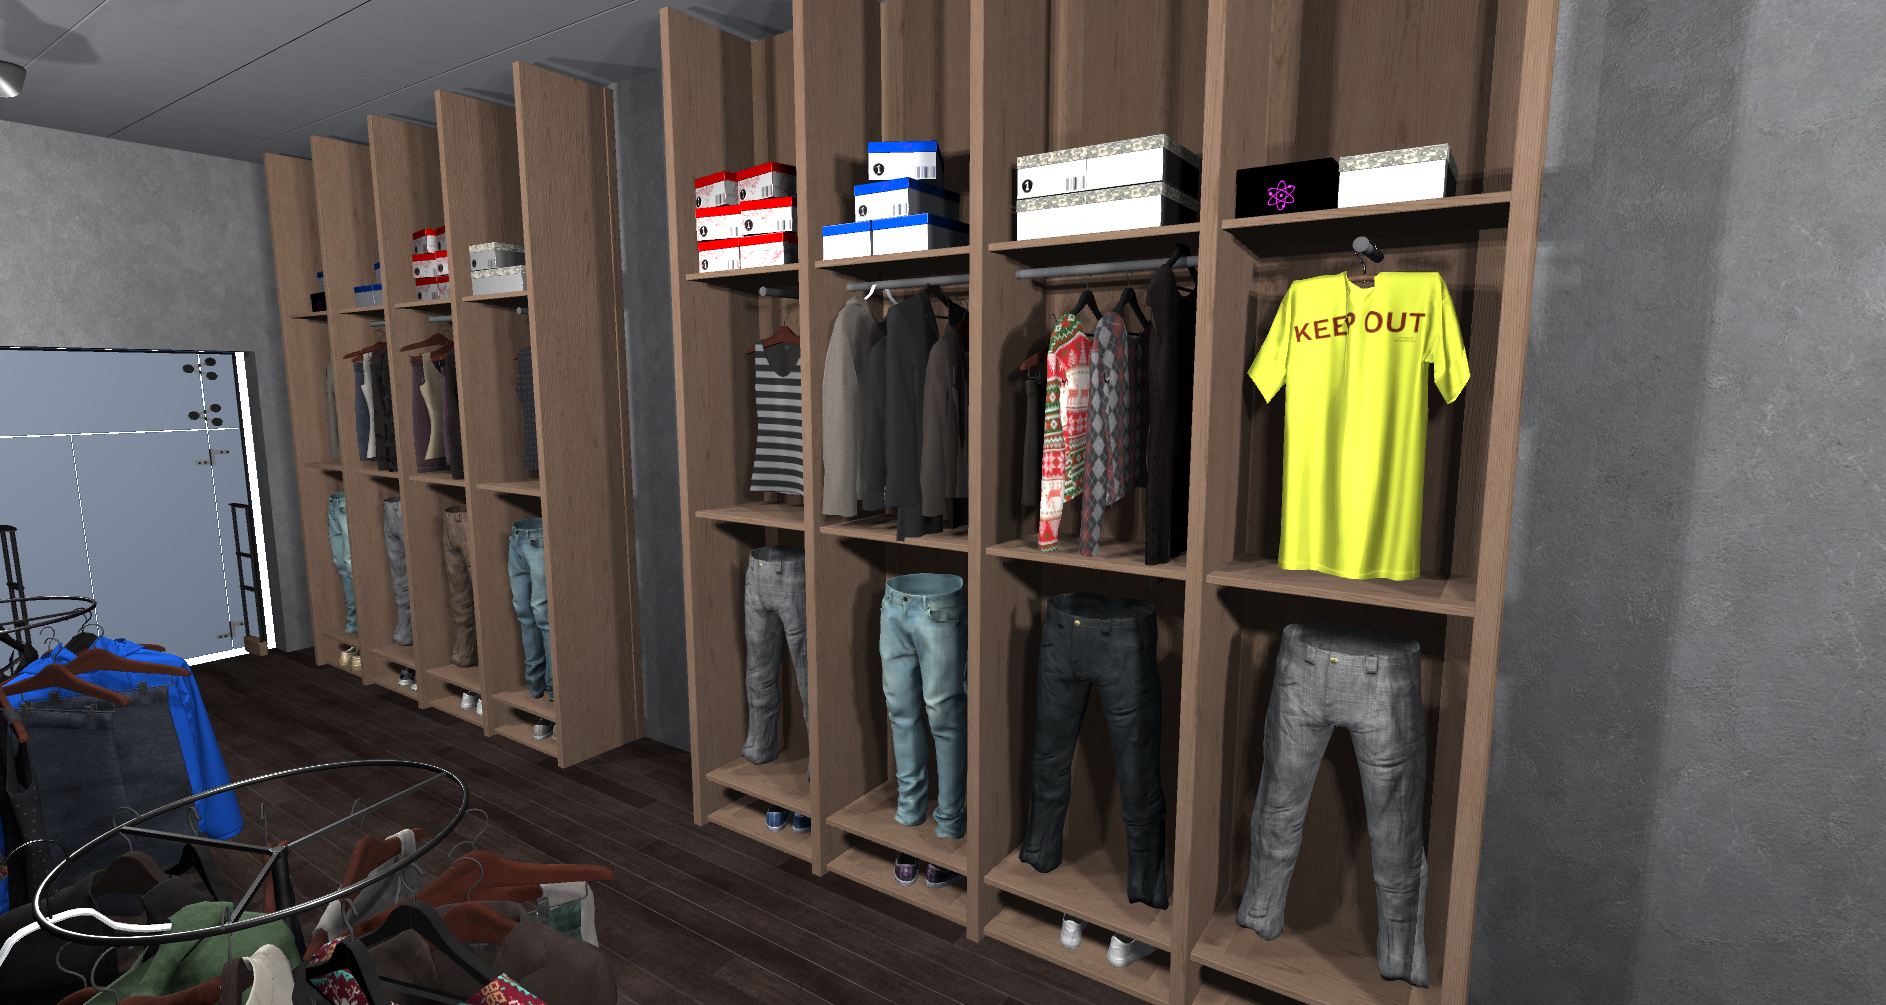

In [13]:
eval_dset[20]["image"]

dialog_id 6540
gt {'turn_idx': 3, 'system_transcript': 'Which pants are you referring to?', 'system_transcript_annotated': {'act': 'REQUEST:DISAMBIGUATE', 'act_attributes': {'slot_values': {}, 'request_slots': [], 'objects': []}}, 'transcript': 'Can you also tell me the customer reviews of the pants in the lower row?', 'transcript_annotated': {'act': 'ASK:GET', 'act_attributes': {'slot_values': {}, 'request_slots': ['customerReview'], 'objects': []}, 'disambiguation_label': 1, 'disambiguation_candidates': [16, 17, 18, 19, 25, 32, 36, 37], 'disambiguation_candidates_raw': [16, 17, 18, 19, 25, 32, 36, 37]}}

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=2099x790 at 0x7FCE380873D0>, 'image_id': 200, 'objects': [{'area': None, 'bbox': [1250.0, 434.0, 119.0, 20.0], 'category_id': 8, 'id': 12, 'index': 16, 'iscrowd': False, 'segmentation': []}, {'area': None, 'bbox': [1297.0, 430.0, 105.0, 17.0], 'category_id': 9, 'id': 13, 'index': 17, 'iscrowd': False, 'segmentation': []}

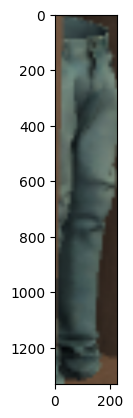

In [14]:
import matplotlib.pyplot as plt
index = 200
object_id = 0
# print(meta_dset[index])
# print()
print("dialog_id", eval_dset[index]["dialog_id"])
print("gt", gold_data_pool[eval_dset[index]["dialog_id"]]["dialogue"][eval_dset[index]["turn_id"]]) #["transcript_annotated"]["disambiguation_candidates"])
print()
print(eval_dset[index])
print()
plt.imshow(eval_transforms(eval_dset[index]["image"].convert("RGB").crop((
    eval_dset[index]['objects'][object_id]['bbox'][0],
    eval_dset[index]['objects'][object_id]['bbox'][1],
    eval_dset[index]['objects'][object_id]['bbox'][0] + max(5, eval_dset[index]['objects'][object_id]['bbox'][3]),
    eval_dset[index]['objects'][object_id]['bbox'][1] + max(5, eval_dset[index]['objects'][object_id]['bbox'][2]),
))))


In [15]:
import torch

model, postprocessor = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5', pretrained=True, return_postprocessor=True)

/home/holy/anaconda3/envs/ambican/lib/python3.10/site-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ashkamath/mdetr/zipball/main" to /home/holy/.cache/torch/hub/main.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /home/holy/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth
Some weights of the

  0%|          | 0.00/2.53G [00:00<?, ?B/s]

In [16]:
model

MDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_

In [38]:
import os
os.system('pip install gradio==2.3.0a0')
os.system('pip freeze')
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import gradio as gr

torch.hub.download_url_to_file('https://cdn.pixabay.com/photo/2014/03/04/15/10/elephants-279505_1280.jpg', 'elephant.jpg')

torch.set_grad_enabled(False);
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.savefig('foo.png',bbox_inches='tight')
    return 'foo.png'


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))
model, postprocessor = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5', pretrained=True, return_postprocessor=True)
model = model.cuda()
model.eval();


def plot_inference(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im.convert("RGB")).unsqueeze(0).cpu()

  # propagate through the model
  memory_cache = model(img, [caption], encode_and_save=True)
  outputs = model(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  return plot_results(im, probas[keep], bboxes_scaled, labels)

absl-py==1.3.0
aiohttp==3.8.3
aiosignal==1.2.0
analytics-python==1.4.0
anyio @ file:///tmp/build/80754af9/anyio_1644481695334/work/dist
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///tmp/build/80754af9/argon2-cffi-bindings_1644553347904/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
async-timeout==4.0.2
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backoff==1.10.0
bcrypt==4.0.1
beautifulsoup4 @ file:///opt/conda/conda-bld/beautifulsoup4_1650462163268/work
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
brotlipy==0.7.0
cachetools==5.2.0
certifi @ file:///croot/certifi_1665076670883/work/certifi
cffi @ file:///tmp/abs_98z5h56wf8/croots/recipe/cffi_1659598650955/work
charset-normalizer==2.1.1
click==8.1.3
contourpy==1.0.5
cryptography @ file:///tmp/buil

  0%|          | 0.00/344k [00:00<?, ?B/s]

Using cache found in /home/holy/.cache/torch/hub/ashkamath_mdetr_main
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
eval_dset[0]["dialogue"][0]

'Please show me some blouses.'

/home/holy/.cache/torch/hub/ashkamath_mdetr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


'foo.png'

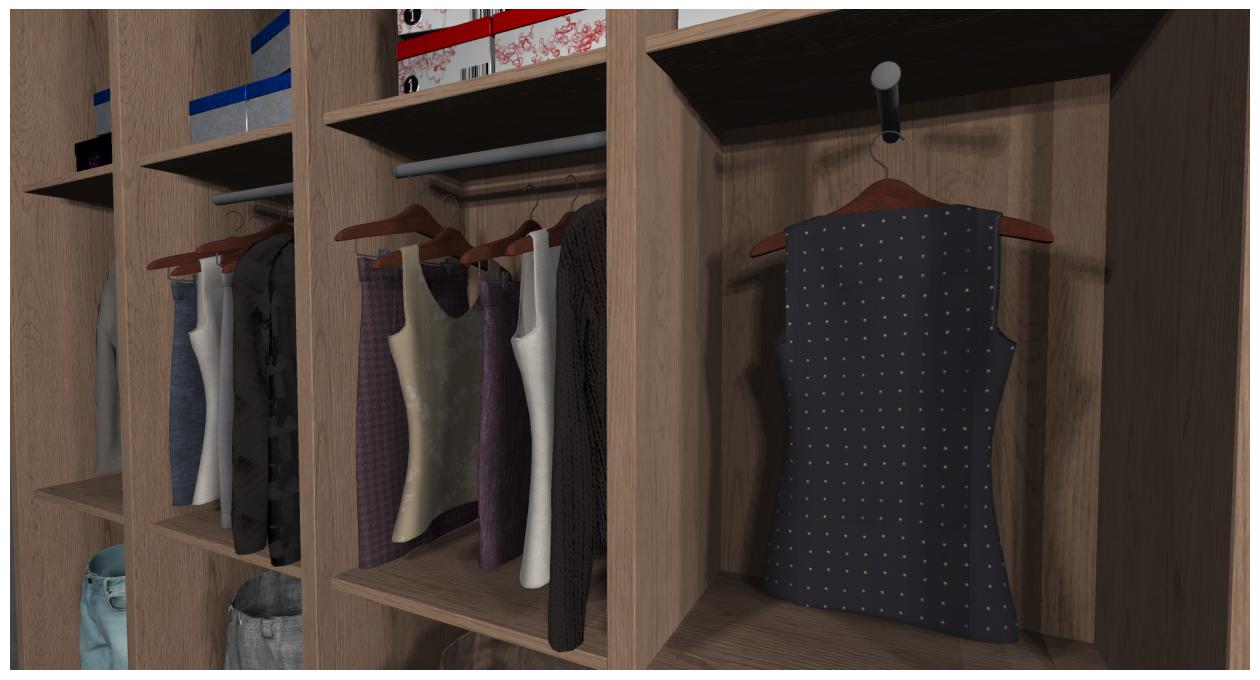

In [30]:
plot_inference(eval_dset[0]["image"], "polkadot top on the right")

In [36]:
img, caption = [transform(eval_dset[0]["image"].convert("RGB"))], ["polkadot top on the right"]
memory_cache = model(img, caption, encode_and_save=True)
outputs = model(img, caption, encode_and_save=False, memory_cache=memory_cache)

/home/holy/.cache/torch/hub/ashkamath_mdetr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [37]:
outputs

{'pred_logits': tensor([[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]),
 'pred_boxes': tensor([[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan,

U: I need a new blouse.
S: Ok, what do you think of these? I have a black blouse in the bottom center of the wall display, another black blouse directly above it, and a white and black blouse to the right of that.
U: Those aren't bad. I'd like something kinda like those two on the top in terms of display and available sizes, but more expensive and with reviews to match.
S: I'm sorry, I don't have anything like that at the moment. Could I help you with something else?
U: Yeah, go ahead and add that white and black blouse to my cart, would you?

((793, 1), (1050, 329))


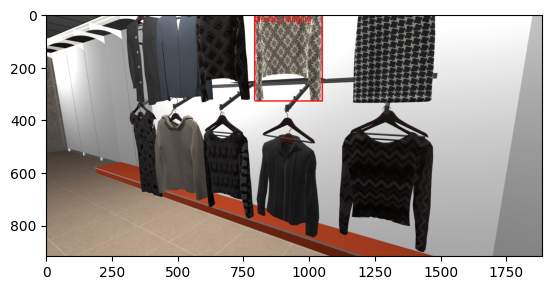

In [ ]:
index = 40
show_dialogue(raw_data['data'][index])
print()
show_image(raw_data['data'][index])

In [11]:
scene_path = row['image_name'].replace('.png','_scene.json')

if os.path.exists(f"{scene_dir_path}/{scene_path}"):
    scene_path = f"{scene_dir_path}/{scene_path}"
elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
    scene_path = f"{scene_dir_path}/m_{scene_path}"
scene = json.load(open(scene_path, 'r'))

NameError: name 'row' is not defined

In [12]:
scene['scenes'][0]['objects']

NameError: name 'scene' is not defined

In [13]:
gt_data['dialogue_data'][0]['dialogue_idx'], gt_data['dialogue_data'][0]['dialogue'][0]['turn_idx']
gt_data['dialogue_data'][0]['dialogue'][6]['transcript_annotated']['disambiguation_candidates']

NameError: name 'gt_data' is not defined

In [12]:
data_path = './preprocessed_data/ambiguous_candidates/simmc2.1_ambiguous_candidates_dstc11_devtest.json'
with open(data_path, "r") as file_id:
    raw_data = json.load(file_id)
data = raw_data["data"]

In [ ]:
import pandas as pd

In [41]:
df= pd.DataFrame({'d': [1,1,1,2,2,2], 't': [1,1,2,1,2,2], 'p': [1,2,3,4,5,6]})
df.groupby(['d','t'])['p'].apply(list).reset_index().to_dict('records')

[{'d': 1, 't': 1, 'p': [1, 2]},
 {'d': 1, 't': 2, 'p': [3]},
 {'d': 2, 't': 1, 'p': [4]},
 {'d': 2, 't': 2, 'p': [5, 6]}]

In [15]:
num_utterances = 3
scene_dir_path = "./simmc2/data/public"
data_path = './preprocessed_data/ambiguous_candidates/simmc2.1_ambiguous_candidates_dstc11_devtest.json'
img_dir_paths = [
    './simmc2/data/simmc2_scene_images_dstc10_public_part1',
    './simmc2/data/simmc2_scene_images_dstc10_public_part2'
]

with open(data_path, "r") as file_id:
    raw_data = json.load(file_id)    
    source_data = json.load(open(raw_data['source_path'],'r'))
data = raw_data["data"]
gt_data = source_data['dialogue_data']

dset = {
    'utterance_id': [], 'object_id': [],
    'text': [], 'image': [], 'bbox': []
}

for row in data:
    # Dialogue idx to labels
    dialog_id = row['dialog_id']
    turn_id = row['turn_id']
    labels = row['ambiguous_candidates']

    if not (dialog_id == 10912 and turn_id == 8):
        continue

    # Scene
    scene_path = row['image_name'].replace('.png','_scene.json')
    if os.path.exists(f"{scene_dir_path}/{scene_path}"):
        scene_path = f"{scene_dir_path}/{scene_path}"
    elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
        scene_path = f"{scene_dir_path}/m_{scene_path}"

    scene = json.load(open(scene_path, 'r'))
    scene_dict = {}
    for scene_objects in scene['scenes']:
        for obj in scene_objects['objects']:
            scene_dict[obj['unique_id']] = obj['bbox']

    image_path = data[0]['image_name']
    for img_dir_path in img_dir_paths:
        if os.path.exists(f'{img_dir_path}/{image_path}'):
            image_path = f'{img_dir_path}/{image_path}'
            break

    dialogue = deepcopy(data[0]["input_text"])
    for turn_id, turn in enumerate(dialogue):
        if turn_id % 2 == 0:
            dialogue[turn_id] = "<USER> " + turn
        else:
            dialogue[turn_id] = "<SYS> " + turn
    text = " ".join(dialogue[-num_utterances:])
    break

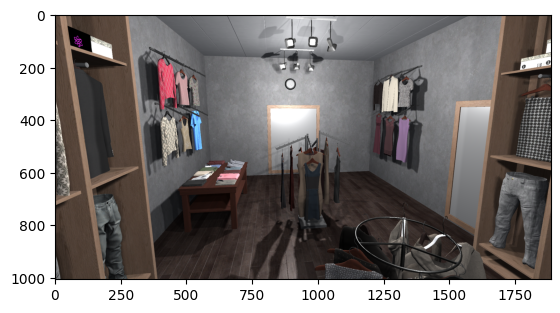

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open(image_path).convert('RGB'))

In [ ]:
np.array(Image.open(image_path).convert('RGB')).shape

(1005, 1886, 3)

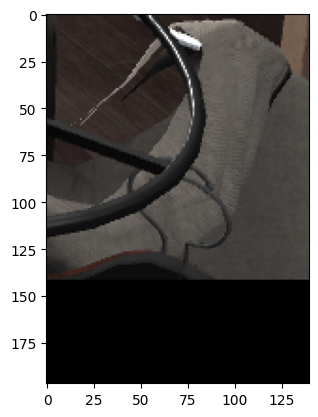

In [ ]:
plt.imshow(Image.open(image_path).convert('RGB').crop([1461, 863, 1461+140, 863+197]))

{'objects': [{'prefab_path': 'MensCollection/Prefabs/Rearranged/jacket_2_03',
   'unique_id': 0,
   'index': 4,
   'bbox': [1116, 378, 33, 18],
   'position': [-1.8927173614501953,
    -1.3044729232788086,
    0.14418506622314453]},
  {'prefab_path': 'WomensCollection/Prefabs/Rearranged/blouse_2_15',
   'unique_id': 1,
   'index': 56,
   'bbox': [29, 450, 136, 27],
   'position': [-2.9001598358154297, 1.8430695533752441, -2.214702844619751]},
  {'prefab_path': 'WomensCollection/Prefabs/Rearranged/blouse_01_62',
   'unique_id': 2,
   'index': 57,
   'bbox': [129, 463, 106, 52],
   'position': [-3.68367862701416, 1.8414487838745117, -2.2199110984802246]},
  {'prefab_path': '870230/hoodie04',
   'unique_id': 3,
   'index': 58,
   'bbox': [198, 437, 129, 41],
   'position': [-4.290022373199463, 2.065037488937378, -2.2163619995117188]},
  {'prefab_path': 'MensCollection/Prefabs/Rearranged/jacket_2_06',
   'unique_id': 4,
   'index': 59,
   'bbox': [198, 449, 128, 28],
   'position': [-5.896

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, VisionTextDualEncoderModel, VisionTextDualEncoderProcessor

model = VisionTextDualEncoderModel.from_pretrained("./save/text-im-align/CLIP__last/vit-base-patch32__roberta-base")
processor = VisionTextDualEncoderProcessor.from_pretrained("./save/text-im-align/CLIP__last/vit-base-patch32__roberta-base")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url_2 = "https://onlinejpgtools.com/images/examples-onlinejpgtools/sunflower.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_2 = Image.open(requests.get(url_2, stream=True).raw)

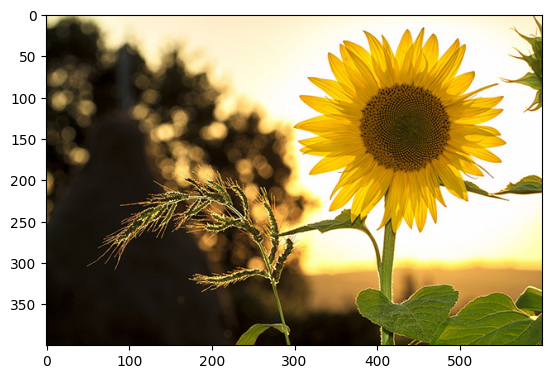

In [ ]:
plt.imshow(image_2)

In [ ]:
inputs = processor(text=["I want to get that cat"], images=[image, image_2, image], return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

outputs

CLIPOutput(loss=None, logits_per_image=tensor([[15.4830],
        [15.4832],
        [15.4830]], grad_fn=<PermuteBackward0>), logits_per_text=tensor([[15.4830, 15.4832, 15.4830]], grad_fn=<MulBackward0>), text_embeds=tensor([[ 4.0531e-02, -3.5118e-02,  5.4270e-02,  1.5643e-02,  1.1779e-02,
          7.2287e-02,  2.9793e-02, -2.4442e-02, -4.2052e-02,  2.5055e-02,
         -6.6999e-02, -5.2777e-02,  6.2316e-02, -1.9657e-02, -4.8642e-02,
          1.7774e-02, -6.4834e-02, -3.2161e-02, -1.0373e-02, -2.6806e-03,
         -9.5809e-02, -2.0541e-02,  3.7419e-02,  7.0741e-03, -3.9970e-02,
         -9.4345e-02, -4.7105e-02,  6.6801e-02, -5.2718e-02,  7.8980e-02,
         -5.3109e-03,  2.7226e-02,  1.0684e-02,  2.8160e-02,  6.1839e-02,
          4.8572e-02,  3.1276e-03,  3.5988e-02,  4.3280e-02, -9.3868e-02,
         -1.5002e-02, -5.9429e-02,  2.7115e-02, -4.0420e-02,  5.0762e-02,
          8.1964e-03,  1.0253e-01,  1.9053e-03,  7.6890e-02, -1.3554e-02,
         -3.5202e-02,  4.9118e-02,  1.2635e

In [ ]:
import torch
torch.cat([torch.eye(10), torch.eye(10) + 2, torch.eye(10) + 4]).T.numpy().diagonal()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [ ]:
np.concatenate([np.ones(10), np.array([[]]).diagonal()])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
import pandas as pd
df = pd.DataFrame({'d':[1,1,1,1,2,2,2,2], 't':[1,1,2,2,1,1,2,2], 'o':[1,2,3,4,1,2,3,4], 'l':[0.5, 0.8, 0.3, 0.1, 0.7, 0.6, 0.2, 0.4]})

In [ ]:
df.groupby(['d', 't']).agg({'o': list, 'l': list}).reset_index()

d  t       o           l
0  1  1  [1, 2]  [0.5, 0.8]
1  1  2  [3, 4]  [0.3, 0.1]
2  2  1  [1, 2]  [0.7, 0.6]
3  2  2  [3, 4]  [0.2, 0.4]

In [107]:
np.where(np.arange(10, 25, 1)>15)[]

[6, 7, 8, 9, 10, 11, 12, 13, 14]

In [349]:
task_list = [
    'indspeech_digit_cdsr_nusantara_sptext',
    'indspeech_news_lvcsr_nusantara_sptext',
    'indspeech_teldialog_lvcsr_nusantara_sptext',
    'indspeech_teldialog_svcsr_nusantara_sptext',
    'librivox_indonesia_ind_nusantara_sptext',
    'titml_idn_nusantara_sptext'
    'indspeech_newstra_ethnicsr_nooverlap_sun_nusantara_sptext',
    'indspeech_news_ethnicsr_su_nooverlap_nusantara_sptext',
    'librivox_indonesia_sun_nusantara_sptext',
    'su_id_asr_nusantara_sptext',
    'indspeech_newstra_ethnicsr_nooverlap_jav_nusantara_sptext',
    'indspeech_news_ethnicsr_jv_nooverlap_nusantara_sptext',
    'librivox_indonesia_jav_nusantara_sptext',
    'jv_id_asr_nusantara_sptext',
    'indspeech_newstra_ethnicsr_nooverlap_ban_nusantara_sptext',
    'librivox_indonesia_ban_nusantara_sptext',
    'indspeech_newstra_ethnicsr_nooverlap_btk_nusantara_sptext',
    'librivox_indonesia_ace_nusantara_sptext',
    'librivox_indonesia_bug_nusantara_sptext',
    'librivox_indonesia_min_nusantara_sptext',
]

In [352]:
for task in task_list:
    name = task.split('_nusantara_')[0]
    print(f"""
CUDA_VISIBLE_DEVICES=4 python src/train.py --model_name_or_path=facebook/wav2vec2-large-xlsr-53 \\
   --task_config_name {task} \\
   --preprocessing_num_workers=16 --audio_column_name=audio --text_column_name=text \\
   --per_device_train_batch_size=16 --per_device_eval_batch_size=16 \\
   --dataloader_num_workers=16 --dataloader_pin_memory \\
   --seed=14045 --num_train_epochs=30 --learning_rate=5e-5 --fp16 \\
   --logging_strategy=steps --logging_steps=10 --report_to=tensorboard \\
   --evaluation_strategy=epoch --eval_steps=1 --eval_accumulation_steps=1 \\
   --save_strategy=epoch --save_steps=1 --save_total_limit=3 --load_best_model_at_end \\
   --metric_for_best_model=mer --greater_is_better=False \\
   --gradient_checkpointing=True \\
   --cache_dir=./cache/{name}/ \\
   --output_dir=./save/{name}/
    """)


CUDA_VISIBLE_DEVICES=4 python src/train.py --model_name_or_path=facebook/wav2vec2-large-xlsr-53 \
   --task_config_name indspeech_digit_cdsr_nusantara_sptext \
   --preprocessing_num_workers=16 --audio_column_name=audio --text_column_name=text \
   --per_device_train_batch_size=16 --per_device_eval_batch_size=16 \
   --dataloader_num_workers=16 --dataloader_pin_memory \
   --seed=14045 --num_train_epochs=30 --learning_rate=5e-5 --fp16 \
   --logging_strategy=steps --logging_steps=10 --report_to=tensorboard \
   --evaluation_strategy=epoch --eval_steps=1 --eval_accumulation_steps=1 \
   --save_strategy=epoch --save_steps=1 --save_total_limit=3 --load_best_model_at_end \
   --metric_for_best_model=mer --greater_is_better=False \
   --gradient_checkpointing=True \
   --cache_dir=./cache/indspeech_digit_cdsr/ \
   --output_dir=./save/indspeech_digit_cdsr/
    

CUDA_VISIBLE_DEVICES=4 python src/train.py --model_name_or_path=facebook/wav2vec2-large-xlsr-53 \
   --task_config_name indspeech